# Loan pay-off status prediction model (using Machine Learning)
The purpose of this project is building a prediction model for loan status using Machine Learning (including deep learning)

the data sets are from Kaggle's Lending Club Loan Data. It is composed of loan.csv, LCDataDicctionary.xlsx and database.sqlite. Lending Club is a loan company which provides diverse loans, such as mortgagse and short-term debts

URL : https://www.kaggle.com/wendykan/lending-club-loan-data/data

Data analysis work flow
1. Scanning data set
2. Planning data analysis purpose
3. Exploratory Data analysis 
4. Data pre-processing
5. Comparison of statistical models
6. Model fine-tunnig
7. Results

### Scanning data set (excel)
Using excel, i scanned through overall variables and data characteristics of loan.csv. The characteristics of varialbes are as follow

1. Variables can be categorized into three groups
    a. variables containing data direclty related to LC(Lending Club)'s customers' financial status
    b. variables indirectly realted to customers' financial stauts
    c. Varaibles regarding types of loans 
2. 5~10 variables contain signifiactly many missing values
3. There are variables whose data contain similar information with others, such as zip code and states.
4. There are varibles, such as 'title' and 'desc', whose data are natural language
5. This data set seems not to be gathered for a specific purpose. Many of the data are mis arranged(classified) 

### Planning data analysis process
Setting Data Analysis Purpose:

Considering the characteristics of Lending Club, its most interest is recognizing customers who will fully pay off their loans. Given limits of the data, I decided to build a model for predicting , among the curret customers, who are likley to pay back thier loans or not
For this purpose, i am going to use 'loan_stauts' variable as an independent varaible y.

In [142]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [143]:
df1 = pd.read_csv('loan.csv')

C:\Users\Changsik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
df = df1.copy()

Based on the grouping of the values of 'loan_status', it is cateorized more specifically then just 'fully paid or nor'

In [145]:
display(df.groupby('loan_status').size())

loan_status
Charged Off                                             45248
Current                                                601779
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Does not meet the credit policy. Status:Fully Paid       1988
Fully Paid                                             207723
In Grace Period                                          6253
Issued                                                   8460
Late (16-30 days)                                        2357
Late (31-120 days)                                      11591
dtype: int64

### Data pre-processing & Exploratory data analysis
For the ease of analyzing data, i pre-selected variables which seem to provide valuable information at prediciting 'loan_status. I created an additional column in LCDataDictionary excel file and entered value '1' to the row which is placed right next to the variables i am going to analyze late

In [146]:
df_name = pd.read_excel('LCDataDictionary.xlsx')

In [147]:
# LCDataDictionary is an excel file containing variable description. I created a column whoes value is either none, or 1
# the row with vlaue 1 means the variable in that row seems to be necessary in predicting who are going to charge-off
# Thus, i created 'needed_columns' list containing the names of columns i am going to use in my model
df_name = df_name[df_name['number'] == 1]
needed_columns = [name for name in df_name.iloc[:, 0]]

As some of the variables i selected fo LCDataDictionary file does not exitst in loan.csv, i deleted those not in the column names of loan.csv

In [148]:
# needed_columns has varaibles whcih does not exist in 'df' of the loan.csv
column_names = []
for x in needed_columns:
    if x in df.columns:
        column_names.append(x)
df = df[column_names]

'loan_status' can be categorized into three groups: 
 1. fully paid, 
 2. paid off late (Default, In Grace Period, Late(16-30), Late(31-120)),
 3. charged off (note likely to be collected in the future)
 
 the two other groups, which are "Does not meet the credit policy. Status:Charged Off" and "Does not meet the credit policy. Status:Fully Paid", are redundent information. When it comes to "Current", it does not provied anty information on final loan status(whther it got fuly paid or not). Thus, i deleted them

In [149]:
# i am not interested in the loan currently on going
lis = ['Current','Issued','Does not meet the credit policy. Status:Charged Off' ,'Does not meet the credit policy. Status:Fully Paid']
for x in lis:
    df = df[df['loan_status'] != x]

In [150]:
display(df.groupby('loan_status').size())

loan_status
Charged Off            45248
Default                 1219
Fully Paid            207723
In Grace Period         6253
Late (16-30 days)       2357
Late (31-120 days)     11591
dtype: int64

In [151]:
lis = []
for x in df['loan_status']:
    if x == 'Charged Off':
        lis.append('charged_off')
    elif x == 'Fully Paid':
        lis.append('fully_paid')
    else:
        lis.append('late')


In [152]:
status_lis = lis

In [153]:
status = pd.DataFrame({'loan_status' : lis})
df['loan_status'] = status['loan_status'].values

In [154]:
display(df.groupby('loan_status').size())

loan_status
charged_off     45248
fully_paid     207723
late            21420
dtype: int64

When i scanned through loan.csv, i could find variables containing significat proportion of missing values. thus, I coded the find variables whose proportion of missing values to the overall data is more than 40%

In [155]:
check_null = df.isnull().sum().sort_values(ascending=False)/len(df)
print(check_null[check_null>0.3])

annual_inc_joint               0.999978
inq_last_12m                   0.999176
total_cu_tl                    0.999176
inq_fi                         0.999176
all_util                       0.999176
open_rv_24m                    0.999176
open_il_24m                    0.999176
open_il_6m                     0.999176
open_acc_6m                    0.999176
mths_since_last_record         0.871618
mths_since_last_major_derog    0.803510
desc                           0.671134
mths_since_last_delinq         0.549329
dtype: float64


Among varialbes detected above, i decided to retain three variales at the bottom ('mths_since_last_delinq', 'mths_since_last_major_derog','mths_since_last_delinq') for two reasons:
1. Desipte their highg missing vlaue proportion, their information is valuable enough to retain
2. It seems their missing values represent 0 (or, can be replaced by 0) considering their non-null values do not contain 0

When it comes to the varialbe "desc", its information overlap with that of "purpose". Thus, i deleted it

In [156]:
# deleted the variables with high missing values
# decided to keeep the last 3 variables due to the reasons below 
# 1 : it is reasonable to fill the missing values with 0
# 2 : there values are worth enough to keep despite of high propotion of missing values

column = list(check_null[check_null>0.90].index)
for x in column:
    del df[x]
del df['desc']

Filled missing values of the retained three variables with 0.
Based on the definition of those three variables, i thought that it is important whether existence of record(derogatory action, or delinquency), not how long time has passed since those acts(record). Thus, i transformed their data to either 0(if value is 0) or 1 (if value is not 0 ) - i am going to use them as categorical varialbes later

In [157]:
#filled missing values with 0
df['mths_since_last_record'].fillna(value = 0, inplace=True)
df['mths_since_last_major_derog'].fillna(value = 0, inplace=True)
df['mths_since_last_delinq'].fillna(value = 0, inplace=True)

In [158]:
def make_categorical(variable):
    df[variable] = df[variable].apply(lambda x: 0 if x == 0.0 else 1.0)
    return df[variable]

In [159]:
lis = ['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq']
for x in lis:
    make_categorical(x)

Checked if there are other variables which have missing values, and filled their missing values with data of types appropriate for each of them

In [160]:
check_null = df.isnull().sum().sort_values(ascending=False)/len(df)
checked_null = check_null[check_null != 0]
print(checked_null)

tot_cur_bal           0.233025
tot_coll_amt          0.233025
emp_title             0.055505
last_credit_pull_d    0.000080
title                 0.000044
dtype: float64


In [161]:
checked_null = pd.DataFrame(checked_null)
checked_null['index1'] = checked_null.index
lis = []
for x in checked_null['index1']:
    lis.append(x)

Handling with the varialbes containing missing values
1. As i am not going to use datettime date, i delted "ast_credit_pull_d"
2. filled missing values of "title" with "no_title"
3. filled that of "tot_cur_bal" with mean
4. filled that of "'tot_coll_amt'" with 0 as its most frequent value is 0 


In [162]:
display(df[lis].head())

,tot_cur_bal,tot_coll_amt,emp_title,last_credit_pull_d,title
0,NaN,NaN,NaN,Jan-2016,Computer
1,NaN,NaN,Ryder,Sep-2013,bike
2,NaN,NaN,NaN,Jan-2016,real estate business
3,NaN,NaN,AIR RESOURCES BOARD,Jan-2015,personel
5,NaN,NaN,Veolia Transportaton,Sep-2015,My wedding loan I promise to pay back


last_credit_pull 변수의 경우 datetime 데이터이고, 또 정확히 어떤 정보를 의미하는지 부정확해서 삭제 하였습니다.
title의 경우 purpose 변수가 대체를 할 수 있기에 삭제했습니다
emp_title 경우 ----
tot_cir_bal 의 경우 편균값으로, tot_coll_amt의 경우 0으로 null값을 변환 신켰습니다

In [163]:
del df['last_credit_pull_d']
del df['emp_title']
del df['title']
df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean(), inplace=True)
df['tot_coll_amt'].fillna(0, inplace=True)

I checked number of groups of values each varaibles and number of values each groups contain, to delete or transfrom to categorical variable  

In [164]:
i = 0
for x in df.columns:
    i = i+1
    if len(df.groupby(x).size())<10:
        print(i, df.groupby(x).size(), '\n')

3 application_type
INDIVIDUAL    274385
JOINT              6
dtype: int64 

8 grade
A    43334
B    79917
C    71584
D    45682
E    22515
F     9016
G     2343
dtype: int64 

9 home_ownership
ANY              1
MORTGAGE    134317
NONE            43
OTHER          141
OWN          24204
RENT        115685
dtype: int64 

10 initial_list_status
f    193471
w     80920
dtype: int64 

11 inq_last_6mths
0.0    134409
1.0     79037
2.0     37511
3.0     17211
4.0      4079
5.0      1523
6.0       557
7.0        46
8.0        18
dtype: int64 

14 loan_status
charged_off     45248
fully_paid     207723
late            21420
dtype: int64 

15 mths_since_last_delinq
0.0    151353
1.0    123038
dtype: int64 

16 mths_since_last_major_derog
0.0    220511
1.0     53880
dtype: int64 

17 mths_since_last_record
0.0    239837
1.0     34554
dtype: int64 

19 policy_code
1.0    274391
dtype: int64 

22 pymnt_plan
n    274384
y         7
dtype: int64 

24 term
 36 months    209857
 60 months     64534
dt

i deleted variables "application_type", 'policy_code' and 'pymnt_plan' for the following reasong:
 - One group of the variable's values contains more than 98% of the number of values

When it comes to the varaible "acc_now_delinq", it has the same characteristics with the variables above. However, i decided to transforming it to categorical variale (0 for 0, 1 for all other values) as i belive it contains information valuable enough to retain

In the case of the variable "home_ownership", the number of values categorized as either 'any', 'none, or 'other' is too small that i grouped them together under the name 'undefined'

In [165]:
lis = ['application_type', 'policy_code', 'pymnt_plan']
for x in lis:
    del df[x]
    
df['home_ownership'] = df['home_ownership'].apply(lambda x : x if x not in ['ANY', 'NONE', 'OTHER'] else 'UNDEFINED')
make_categorical('acc_now_delinq')


0         0.0
1         0.0
2         0.0
3         0.0
5         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
30        0.0
31        0.0
         ... 
887198    0.0
887202    0.0
887215    0.0
887231    0.0
887248    0.0
887249    0.0
887254    0.0
887258    0.0
887263    0.0
887264    0.0
887268    0.0
887275    0.0
887276    0.0
887279    0.0
887280    0.0
887290    0.0
887303    0.0
887308    0.0
887322    0.0
887330    0.0
887332    0.0
887337    0.0
887345    0.0
887346    0.0
887347    0.0
887351    0.0
887364    0.0
887366    0.0
887369    0.0
887371    0.0
Name: acc_now_delinq, Length: 274391, dtype: float64

As the information of "sub_grade" overlabs with that of "grade", i deleted it

In [166]:
del df['sub_grade']

By giving the limit of the number of groups of values as 1000, i tried to find out variables which should be transformed to categorical variable, or is categorical variable whose values to be converted to binary data (one hot encoding to say)

In [167]:
i = 0
for x in df.columns:
    i = i+1
    if len(df.groupby(x).size())<1000:
        print(i, df.groupby(x).size(), '\n')

1 addr_state
AK      717
AL     3470
AR     1918
AZ     6591
CA    46195
CO     6003
CT     3977
DC      866
DE      731
FL    19097
GA     8680
HI     1627
IA        6
ID        6
IL     9933
IN     3128
KS     2213
KY     2426
LA     3236
MA     6621
MD     6567
ME       14
MI     6542
MN     4829
MO     4231
MS      532
MT      802
NC     7572
ND       12
NE       55
NH     1234
NJ    10416
NM     1507
NV     4163
NY    23446
OH     8383
OK     2372
OR     3579
PA     9197
RI     1186
SC     3043
SD      594
TN     2782
TX    21012
UT     2265
VA     8655
VT      455
WA     6321
WI     3307
WV     1240
WY      637
dtype: int64 

3 delinq_2yrs
0.0     228524
1.0      31309
2.0       8874
3.0       3017
4.0       1239
5.0        637
6.0        326
7.0        176
8.0        103
9.0         63
10.0        39
11.0        23
12.0        26
13.0         8
14.0         9
15.0         5
16.0         2
17.0         2
18.0         4
19.0         1
20.0         1
21.0         1
22.0         1
2

In [168]:
for x in df.columns:
    display(df.groupby(x).size())

addr_state
AK      717
AL     3470
AR     1918
AZ     6591
CA    46195
CO     6003
CT     3977
DC      866
DE      731
FL    19097
GA     8680
HI     1627
IA        6
ID        6
IL     9933
IN     3128
KS     2213
KY     2426
LA     3236
MA     6621
MD     6567
ME       14
MI     6542
MN     4829
MO     4231
MS      532
MT      802
NC     7572
ND       12
NE       55
NH     1234
NJ    10416
NM     1507
NV     4163
NY    23446
OH     8383
OK     2372
OR     3579
PA     9197
RI     1186
SC     3043
SD      594
TN     2782
TX    21012
UT     2265
VA     8655
VT      455
WA     6321
WI     3307
WV     1240
WY      637
dtype: int64

annual_inc
3000.00        1
4000.00        1
4080.00        1
4200.00        2
4524.00        1
4800.00        6
4888.00        1
5000.00        2
5500.00        1
6000.00        7
6610.00        1
6635.00        1
6695.00        1
7000.00        4
7200.00        6
7452.00        1
7459.64        1
7500.00        2
7600.00        1
7680.00        1
7740.00        1
7800.00        2
7904.04        1
8000.00       15
8004.00        1
8088.00        4
8208.00        1
8280.00        1
8376.00        1
8391.48        1
              ..
985000.00      1
995000.00      1
1000000.00     5
1080000.00     1
1100000.00     3
1176000.00     1
1200000.00     7
1233000.00     1
1250000.00     2
1300000.00     2
1350000.00     1
1362000.00     1
1440000.00     1
1500000.00     1
1510000.00     1
1650000.00     1
1782000.00     1
1900000.00     2
1950000.00     1
2000000.00     2
2039784.00     1
2146496.00     1
3900000.00     1
4900000.00     1
5000000.00     1
6000000.00     2
6100000.00     1
714

delinq_2yrs
0.0     228524
1.0      31309
2.0       8874
3.0       3017
4.0       1239
5.0        637
6.0        326
7.0        176
8.0        103
9.0         63
10.0        39
11.0        23
12.0        26
13.0         8
14.0         9
15.0         5
16.0         2
17.0         2
18.0         4
19.0         1
20.0         1
21.0         1
22.0         1
29.0         1
dtype: int64

dti
0.00     296
0.01       8
0.02       9
0.03       4
0.04       5
0.05       5
0.06       6
0.07       6
0.08       8
0.09       5
0.11       9
0.12       8
0.13      13
0.14       7
0.15      10
0.16      12
0.17       8
0.18      14
0.19       4
0.20      20
0.21      10
0.22      16
0.23       9
0.24      14
0.25      25
0.26      24
0.27      14
0.28      23
0.29      13
0.30      17
        ... 
39.73      3
39.74      4
39.75      4
39.76      3
39.77      3
39.78      8
39.79      3
39.80      3
39.81      1
39.82      4
39.83      2
39.84      2
39.85      3
39.86      4
39.87      2
39.88      5
39.89      5
39.90      4
39.91      1
39.92      3
39.93      2
39.94      1
39.95      3
39.96      1
39.97      2
39.98      2
39.99      5
57.14      1
59.18      1
59.26      1
Length: 3996, dtype: int64

earliest_cr_line
Apr-1955       1
Apr-1962       1
Apr-1963       1
Apr-1964       6
Apr-1965       3
Apr-1966       7
Apr-1967      12
Apr-1968      11
Apr-1969      12
Apr-1970      22
Apr-1971      14
Apr-1972      16
Apr-1973      32
Apr-1974      28
Apr-1975      35
Apr-1976      47
Apr-1977      61
Apr-1978      82
Apr-1979      96
Apr-1980      94
Apr-1981     107
Apr-1982     119
Apr-1983     157
Apr-1984     177
Apr-1985     237
Apr-1986     260
Apr-1987     301
Apr-1988     370
Apr-1989     430
Apr-1990     467
            ... 
Sep-1983     190
Sep-1984     241
Sep-1985     223
Sep-1986     294
Sep-1987     302
Sep-1988     403
Sep-1989     434
Sep-1990     546
Sep-1991     465
Sep-1992     507
Sep-1993     782
Sep-1994     948
Sep-1995    1202
Sep-1996    1152
Sep-1997    1249
Sep-1998    1541
Sep-1999    1786
Sep-2000    1909
Sep-2001    1857
Sep-2002    1778
Sep-2003    1630
Sep-2004    1385
Sep-2005    1144
Sep-2006    1076
Sep-2007     740
Sep-2008     391
Sep-2009     2

emp_length
1 year       18295
10+ years    83448
2 years      25479
3 years      22170
4 years      17455
5 years      19346
6 years      15855
7 years      15181
8 years      12921
9 years      10436
< 1 year     22738
n/a          11067
dtype: int64

grade
A    43334
B    79917
C    71584
D    45682
E    22515
F     9016
G     2343
dtype: int64

home_ownership
MORTGAGE     134317
OWN           24204
RENT         115685
UNDEFINED       185
dtype: int64

initial_list_status
f    193471
w     80920
dtype: int64

inq_last_6mths
0.0    134409
1.0     79037
2.0     37511
3.0     17211
4.0      4079
5.0      1523
6.0       557
7.0        46
8.0        18
dtype: int64

installment
15.69       1
16.08       1
16.25       1
16.31       1
16.47       1
19.87       1
20.22       1
21.25       1
21.62       1
21.81       1
22.51       1
22.79       1
22.94       1
23.01       1
23.17       1
23.26       1
23.35       1
23.51       1
23.91       1
24.16       1
24.27       1
24.32       1
24.73       1
24.84       1
24.96       1
25.02       1
25.16       1
25.28       1
26.51       1
26.84       1
           ..
1350.84     1
1353.02     4
1353.93    10
1354.66     6
1356.67     5
1358.87     1
1359.96     3
1362.15     3
1362.70     7
1363.98     1
1366.12     1
1366.36     2
1367.65     5
1368.75     1
1370.83     1
1372.97     2
1374.63     6
1379.23     1
1380.63     1
1382.36     1
1388.45     2
1391.41     2
1396.79     1
1402.17     2
1404.95     1
1406.45     5
1407.01     3
1408.13     3
1409.99     1
1424.57     1
Length: 47560, dtype: int64

int_rate
5.32      186
5.42      573
5.79      410
5.93      128
5.99      347
6.00       51
6.03     4936
6.17      252
6.24      210
6.39      265
6.49     1044
6.54      305
6.62     3581
6.68      208
6.76      168
6.89      208
6.91      303
6.92      584
6.97      188
6.99      613
7.05       23
7.12      703
7.14      341
7.26      285
7.29      387
7.37       31
7.40       72
7.42        7
7.43       26
7.49     1095
         ... 
23.70     305
23.76     258
23.83     225
23.91      12
23.99     405
24.08     865
24.11       8
24.20      26
24.33      19
24.40       1
24.50    1099
24.52       4
24.70     142
24.76       5
24.83      78
24.89     216
24.99     807
25.28     111
25.57     556
25.78      75
25.80     481
25.83     370
25.89     281
25.99     186
26.06     159
26.77      65
27.31      55
27.88      27
28.49      23
28.99      26
Length: 513, dtype: int64

loan_status
charged_off     45248
fully_paid     207723
late            21420
dtype: int64

mths_since_last_delinq
0.0    151353
1.0    123038
dtype: int64

mths_since_last_major_derog
0.0    220511
1.0     53880
dtype: int64

mths_since_last_record
0.0    239837
1.0     34554
dtype: int64

open_acc
0.0         6
1.0        49
2.0      1282
3.0      3747
4.0      8041
5.0     13413
6.0     19079
7.0     22616
8.0     25050
9.0     26280
10.0    24835
11.0    22912
12.0    20218
13.0    16922
14.0    14208
15.0    11461
16.0     9507
17.0     7509
18.0     6094
19.0     4882
20.0     3731
21.0     2930
22.0     2275
23.0     1729
24.0     1393
25.0     1011
26.0      720
27.0      580
28.0      396
29.0      308
30.0      247
31.0      178
32.0      173
33.0      130
34.0      103
35.0       70
36.0       63
37.0       51
38.0       36
39.0       28
40.0       24
41.0       20
42.0       17
43.0       13
44.0        8
45.0        8
46.0        7
47.0        7
48.0        3
49.0        4
50.0        3
51.0        1
52.0        3
53.0        2
54.0        2
55.0        1
56.0        1
58.0        2
76.0        2
dtype: int64

pub_rec
0.0     239834
1.0      30334
2.0       2962
3.0        802
4.0        249
5.0        109
6.0         53
7.0         20
8.0          9
9.0          7
10.0         5
11.0         3
12.0         2
15.0         1
20.0         1
dtype: int64

purpose
car                     3781
credit_card            53936
debt_consolidation    162080
educational              325
home_improvement       16142
house                   1772
major_purchase          6662
medical                 3067
moving                  2195
other                  15383
renewable_energy         284
small_business          5084
vacation                1714
wedding                 1966
dtype: int64

term
 36 months    209857
 60 months     64534
dtype: int64

total_acc
2.0         16
3.0        311
4.0       1021
5.0       1568
6.0       2272
7.0       3045
8.0       3971
9.0       4675
10.0      5585
11.0      6242
12.0      6974
13.0      7846
14.0      8173
15.0      8735
16.0      9078
17.0      9581
18.0      9594
19.0      9709
20.0     10020
21.0      9979
22.0      9909
23.0      9661
24.0      9445
25.0      9083
26.0      8717
27.0      8395
28.0      8032
29.0      7657
30.0      7189
31.0      6680
         ...  
81.0        16
82.0         8
83.0         9
84.0        10
85.0         8
86.0         2
87.0         9
88.0         8
89.0         4
90.0         6
91.0         6
92.0         4
93.0         3
94.0         2
95.0         2
96.0         1
97.0         1
98.0         2
99.0         3
100.0        1
101.0        1
102.0        2
104.0        1
105.0        1
110.0        1
111.0        1
112.0        1
116.0        1
118.0        1
150.0        1
Length: 109, dtype: int64

total_rec_late_fee
0.000000      265538
0.010000           6
0.060800           1
0.073787           1
0.081838           1
0.101705           1
0.135766           1
0.180083           1
0.184774           1
0.200000           1
0.260000           1
0.265406           1
0.302037           1
0.350000           1
0.440000           1
0.510000           1
0.870000           1
1.000000           3
1.310000           1
1.360000           1
1.690000           1
2.000000           3
3.160000           1
3.230000           1
4.000000           1
4.410000           1
5.000000           5
6.000000           1
6.290000           1
10.000000         12
               ...  
139.560000         1
141.720000         1
142.750000         1
144.420000         1
144.900000         1
145.200000         1
145.530000         1
146.040000         1
146.413751         1
147.650000         1
155.760000         1
155.840000         1
157.500000         1
159.660000         1
165.650151         1
166.140000     

acc_now_delinq
0.0    273508
1.0       883
dtype: int64

tot_coll_amt
0.0          249368
3.0               1
7.0               1
8.0               1
9.0               1
12.0              1
13.0              1
15.0              1
20.0              1
21.0              1
22.0              1
25.0              8
26.0              9
27.0             11
28.0             13
29.0              7
30.0             16
31.0             10
32.0             11
33.0              5
34.0              7
35.0              4
36.0              5
37.0              6
38.0              2
39.0              4
40.0             16
41.0              5
42.0              8
43.0              6
              ...  
53300.0           1
55009.0           2
55513.0           1
56234.0           1
57147.0           1
57186.0           1
57195.0           1
58082.0           1
59924.0           1
60277.0           1
60531.0           1
63787.0           1
64250.0           1
67048.0           1
68652.0           1
70093.0           1
74401.0           1
75081.0           1
77951.0

tot_cur_bal
0.0          53
1.0           1
2.0           2
4.0           1
5.0           1
7.0           1
10.0          2
11.0          2
15.0          2
17.0          2
18.0          1
20.0          1
33.0          1
36.0          1
38.0          1
41.0          1
43.0          1
49.0          1
50.0          1
51.0          2
54.0          1
55.0          1
57.0          1
58.0          1
66.0          1
69.0          1
72.0          1
75.0          4
77.0          1
78.0          1
             ..
1856988.0     1
1890286.0     1
1907327.0     1
1955400.0     1
1967533.0     1
1972493.0     1
1979764.0     1
2008009.0     1
2054629.0     1
2100799.0     1
2113815.0     1
2134998.0     1
2154632.0     1
2203780.0     1
2238193.0     1
2288155.0     1
2302431.0     1
2442195.0     1
2471713.0     1
2547166.0     1
2629423.0     1
2940054.0     1
3128834.0     1
3437283.0     1
3471522.0     1
3610743.0     1
3652389.0     1
3796811.0     1
4772549.0     1
8000078.0     1
Length: 1449

The varialbes whose name is contained in the list below are to be one-hot encoded

In [169]:
get_dummy_list = ['addr_state', 'emp_length', 'grade', 'home_ownership', 'initial_list_status', 'mths_since_last_delinq',
                 'mths_since_last_major_derog', 'mths_since_last_record', 'purpose', 'term', 'acc_now_delinq']
x_inputs = []
float_columns = ['annual_inc', 'delinq_2yrs', 'dti', 'inq_last_6mths', 'installment', 'int_rate', 
                 'open_acc', 'pub_rec', 'total_acc', 'total_rec_late_fee', 'tot_coll_amt', 'tot_cur_bal']
#for x in df.columns:
#    if x not in get_dummy_list:
#        float_columns.append(x)


### Graphical Exploratory data analysis & data transformation

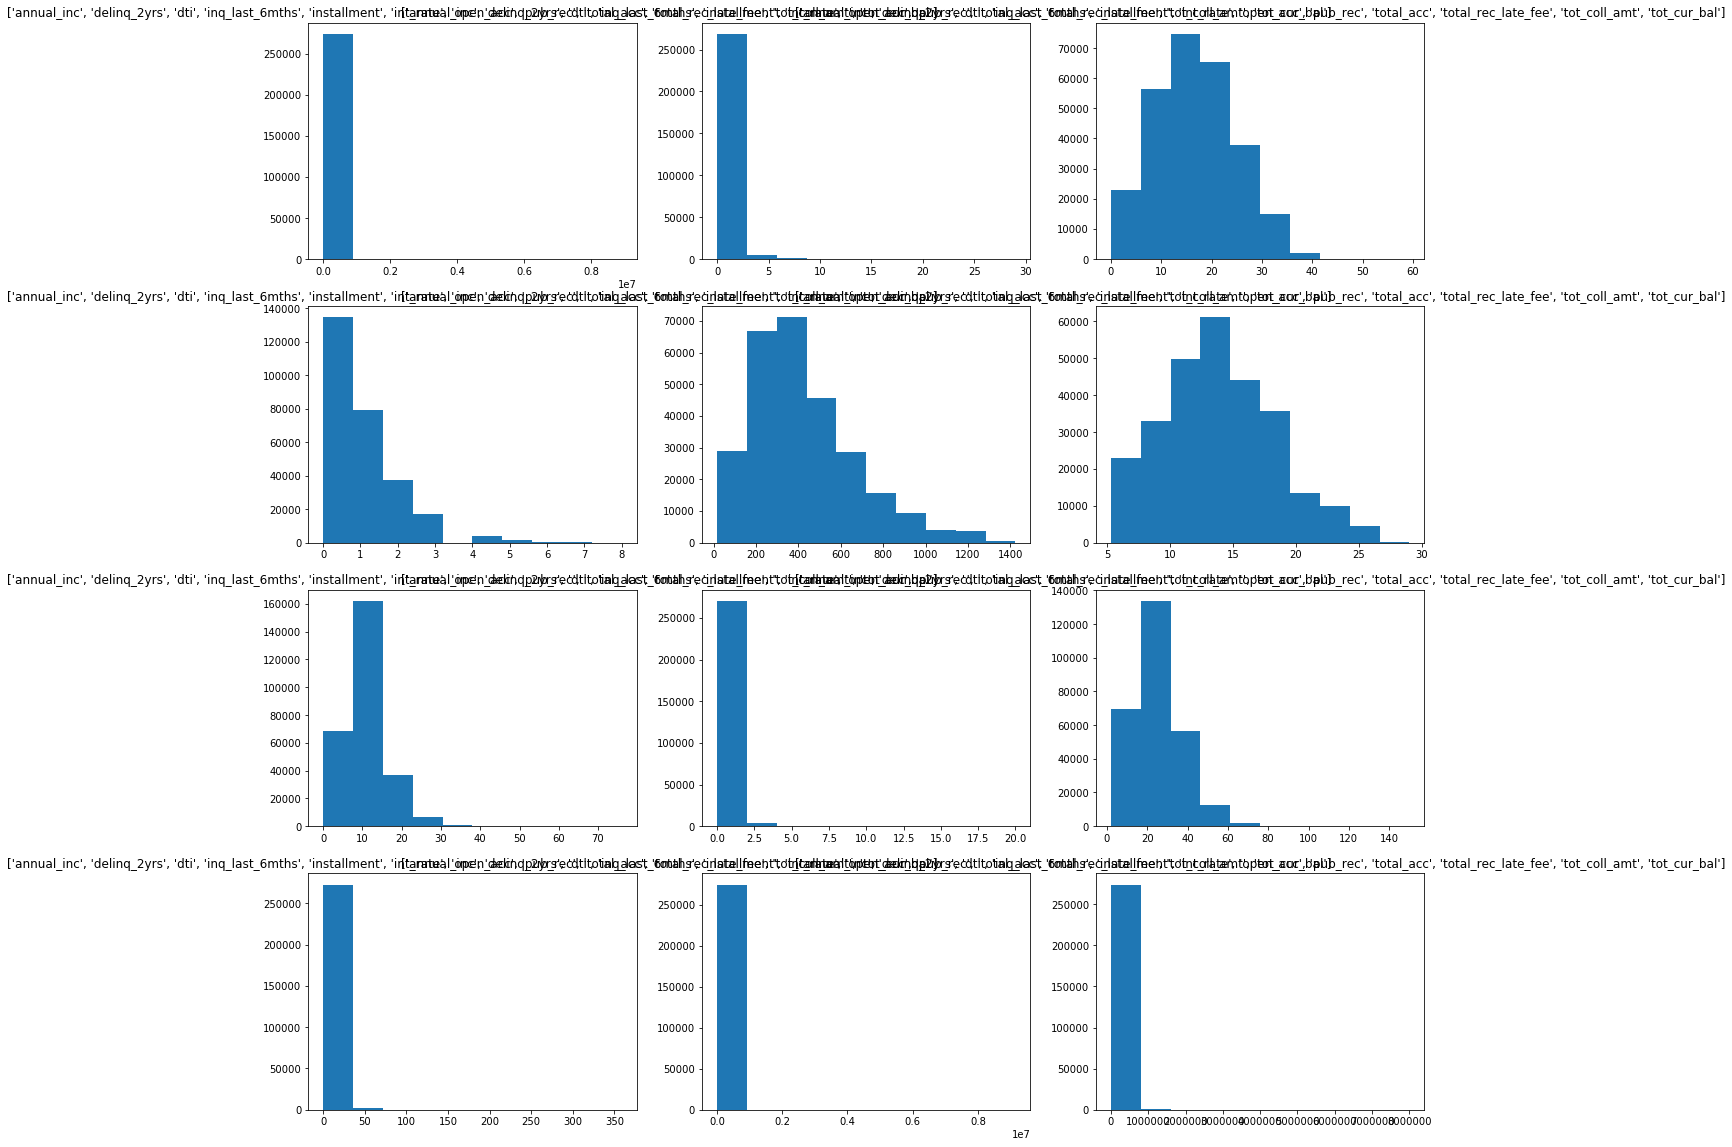

In [170]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(20, 20))
for ax, column in zip(axes.flat, float_columns):
    ax.hist(df[column])
    ax.set(title = float_columns)
plt.show()

Based on the graphs above, it is clear that variables' data are not normally distributed. Thus i applied ln(x+1) to each of the values (I added 1 to  x as many of the data has value 0)

In [171]:
import math

In [172]:
display(df[float_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274391 entries, 0 to 887371
Data columns (total 12 columns):
annual_inc            274391 non-null float64
delinq_2yrs           274391 non-null float64
dti                   274391 non-null float64
inq_last_6mths        274391 non-null float64
installment           274391 non-null float64
int_rate              274391 non-null float64
open_acc              274391 non-null float64
pub_rec               274391 non-null float64
total_acc             274391 non-null float64
total_rec_late_fee    274391 non-null float64
tot_coll_amt          274391 non-null float64
tot_cur_bal           274391 non-null float64
dtypes: float64(12)
memory usage: 37.2 MB


None

In [173]:
loan_stauts = df['loan_status']
del df['loan_status']

In [174]:
for column in float_columns:
    df[column] = df[column].apply(lambda x : math.log(x+1))

In [175]:
pd.set_option('display.max_columns', None)
display(df.head())

,addr_state,annual_inc,delinq_2yrs,dti,earliest_cr_line,emp_length,grade,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,open_acc,pub_rec,purpose,term,total_acc,total_rec_late_fee,acc_now_delinq,tot_coll_amt,tot_cur_bal
0,AZ,10.085851,0.0,3.355153,Jan-1985,10+ years,B,RENT,f,0.693147,5.099073,2.455306,0.0,0.0,0.0,1.386294,0.0,credit_card,36 months,2.302585,0.000000,0.0,0.0,11.826869
1,GA,10.308986,0.0,0.693147,Apr-1999,< 1 year,C,RENT,f,1.791759,4.108083,2.789323,0.0,0.0,0.0,1.386294,0.0,car,60 months,1.609438,0.000000,0.0,0.0,11.826869
2,IL,9.413526,0.0,2.274186,Nov-2001,10+ years,C,RENT,f,1.098612,4.446526,2.830858,0.0,0.0,0.0,1.098612,0.0,small_business,36 months,2.397895,0.000000,0.0,0.0,11.826869
3,CA,10.803669,0.0,3.044522,Feb-1996,10+ years,C,RENT,f,0.693147,5.829857,2.673459,1.0,0.0,0.0,2.397895,0.0,other,36 months,3.637586,2.888704,0.0,0.0,11.826869
5,AZ,10.491302,0.0,2.501436,Nov-2004,3 years,A,RENT,f,1.386294,5.059171,2.186051,0.0,0.0,0.0,2.302585,0.0,wedding,36 months,2.564949,0.000000,0.0,0.0,11.826869


In [176]:
make_categorical('acc_now_delinq')

0         0.0
1         0.0
2         0.0
3         0.0
5         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
30        0.0
31        0.0
         ... 
887198    0.0
887202    0.0
887215    0.0
887231    0.0
887248    0.0
887249    0.0
887254    0.0
887258    0.0
887263    0.0
887264    0.0
887268    0.0
887275    0.0
887276    0.0
887279    0.0
887280    0.0
887290    0.0
887303    0.0
887308    0.0
887322    0.0
887330    0.0
887332    0.0
887337    0.0
887345    0.0
887346    0.0
887347    0.0
887351    0.0
887364    0.0
887366    0.0
887369    0.0
887371    0.0
Name: acc_now_delinq, Length: 274391, dtype: float64

I one-oht encoded all the varilbes of the get_dummy_list using pandas' get_dummies command. Then i merged them with the original datafram 

In [177]:
get_dummy_list = ['addr_state', 'emp_length', 'grade', 'home_ownership','initial_list_status', 'mths_since_last_delinq', 
                 'mths_since_last_major_derog', 'mths_since_last_record', 'purpose', 'term' ]
for x in get_dummy_list:
    x1 = pd.get_dummies(df[x])
    df = pd.concat([df, x1], axis=1)
    

In [178]:
for x in get_dummy_list:
    del df[x]
print(df.head())

   annual_inc  delinq_2yrs       dti earliest_cr_line  inq_last_6mths  \
0   10.085851          0.0  3.355153         Jan-1985        0.693147   
1   10.308986          0.0  0.693147         Apr-1999        1.791759   
2    9.413526          0.0  2.274186         Nov-2001        1.098612   
3   10.803669          0.0  3.044522         Feb-1996        0.693147   
5   10.491302          0.0  2.501436         Nov-2004        1.386294   

   installment  int_rate  open_acc  pub_rec  total_acc  total_rec_late_fee  \
0     5.099073  2.455306  1.386294      0.0   2.302585            0.000000   
1     4.108083  2.789323  1.386294      0.0   1.609438            0.000000   
2     4.446526  2.830858  1.098612      0.0   2.397895            0.000000   
3     5.829857  2.673459  2.397895      0.0   3.637586            2.888704   
5     5.059171  2.186051  2.302585      0.0   2.564949            0.000000   

   acc_now_delinq  tot_coll_amt  tot_cur_bal  AK  AL  AR  AZ  CA  CO  CT  DC  \
0           

In [179]:
del df['earliest_cr_line']

To avoid overfitting due to too many independent variables, i used PCA and reduced dimension of state varialbe(it created 51 variable when one-hot encoded) to 5. Though it might created better dimension reduction with MCA, i cuold not find appropriate python library for it

In [180]:
from sklearn.decomposition import PCA
df_state = df.iloc[:, 13:64]
pca = PCA(n_components=5)
df_state_pca = pca.fit_transform(df_state)


In [181]:
lis = []
for x in status_lis:
    if x == 'charged_off':
        lis.append(1.0)
    elif x == 'fully_paid':
        lis.append(2.0)
    elif x == 'late': 
        lis.append(3.0)

In [182]:
df = df.drop(df.iloc[:, 13:64] ,axis=1)


In [183]:
X = np.array(df)
X = np.concatenate((X, df_state_pca), axis=1)
y = np.array(lis)

In [184]:
#y = np.reshape(y, (1, -1))

In [185]:
print(y.shape, X.shape)

(274391,) (274391, 65)


In [186]:
print(y[0:50])

[ 2.  1.  2.  2.  2.  2.  1.  1.  2.  2.  1.  2.  1.  2.  2.  2.  2.  2.
  2.  1.  2.  2.  1.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  1.  2.  2.  2.  1.  2.  2.  1.]


### Statistical model comparison
To find whether X and y has linear relationship or non-linear relationship, i decided to use SVC-linear, SVC-polynomian, and Random Forest

In [187]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Used train_test_split twice to prevent leaking test set data (or overfitting)

In [188]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=0)

In [189]:
clf_RF = RandomForestClassifier(n_jobs= -1)
clf_RF.fit(X_train, y_train)
scores_RF = cross_val_score(clf_RF, X_valid, y_valid, cv=3)

print('RF', scores_RF.mean())

RF 0.739936617362


Random Forest model generated 83% of prediction accuracy on test data set

In [190]:
print(clf_RF.score(X_test, y_test))

0.741989562378


In [191]:
clf_RF.predict(X_test)

array([ 2.,  2.,  2., ...,  2.,  2.,  1.])

In [192]:
print(classification_report(y_test, clf_RF.predict(X_test)))

             precision    recall  f1-score   support

        1.0       0.33      0.16      0.22     11258
        2.0       0.78      0.94      0.85     51944
        3.0       0.32      0.06      0.10      5396

avg / total       0.67      0.74      0.69     68598



In the case of SVC model, i could not run them due to lack of computational capability

In [193]:
#clf_SVC_lin = SVC(kernel = 'linear')
#clf_SVC_lin.fit(X_train, y_train)

#scores_lin = cross_val_score(clf_SVC_lin, X_valid, y_valid, cv=3)
#print('lin', scores_lin.mean())

In [194]:
#clf_SVC_poly = SVC(kernel = 'poly')
#clf_SVC_poly.fit(X_train, y_train)
#scores_poly = cross_val_score(clf_SVC_poly, X_valid, y_valid, cv=3)
#print('poly', scores_poly.mean())

I tried to predict using Tensorflow

In [205]:
import tensorflow as tf

In [202]:
x_data = X

In [200]:
import sklearn.preprocessing
lis1=map(int, lis)
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(max(lis1)+1))
b = label_binarizer.transform(lis)
y_data = np.delete(b, 0, 1)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=0)

In [210]:
tf.reset_default_graph()

In [211]:
learning_rate = 0.01

# input place holders
X = tf.placeholder("float", [None, 65])
Y = tf.placeholder("float", [None, 3])


# weights & bias for nn layers
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
W1 = tf.get_variable("W1", shape=[65, 30],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([30]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.get_variable("W2", shape=[30, 15],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([15]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[15, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([10]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[10, 3],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([3]))

hypothesis = tf.matmul(L3, W4) + b4

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# train my model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(2000):
        sess.run(optimizer, feed_dict={X: X_train, Y: y_train})
        if step % 100 == 0:
            
            loss = sess.run(cost, feed_dict={X: X_train, Y: y_train})
            print('Loss :', loss )
    print('Learning Finished!')      
    print('Accuracy:', sess.run(accuracy, feed_dict={
      X: X_test, Y: y_test}))


# Test model and check accuracy



Loss : 0.742873
Loss : 0.631888
Loss : 0.628784
Loss : 0.627475
Loss : 0.624059
Loss : 0.623395
Loss : 0.622034
Loss : 0.621275
Loss : 0.620051
Loss : 0.619722
Loss : 0.62225
Loss : 0.618924
Loss : 0.618039
Loss : 0.619123
Loss : 0.6179
Loss : 0.6183
Loss : 0.617306
Loss : 0.618518
Loss : 0.616966
Loss : 0.61685
Learning Finished!
Accuracy: 0.763083


### Model Selection (Deep Learning Model !)

Random Forest gives 73% of prediction score, while deep learning gives 76%
To increase prediction score and compare prediction results more ccurately, further fine_tuning of statisctical model is needed. But due to the lack of computational resource, i temporarily decides to use Deep Learning Model for now